# Essential Machine Learning for Physicists

<p align="right">
  <img src="../../misc/tum-logo.png" width="93" align="right" />
  <img src="../../misc/sixt-logo.png" width="70" align="right" /> 
<left><em>&copy; Zinonas Zinonos</em></left>
    
<left><em>For more information, visit <a href='https://github.com/zinon/essential-machine-learning-for-physicists'>essential-machine-learning-for-physicists</a></em></left>.
___
</p>

# Machine Learning Experiment

The goal of this exercise is to compare the performance of various tree- and ensemble-based machine learning algorithms on a classification problem.

## Experiment Setup

First off, we will synthesize a quite large and rather complex dataset, which will be used as our benchmark dataset for our all experients. Then, we will create many instances of classification models. Each model will be tested and (cross)validated over our train/test sets.
Having our trained models in place, we will compare their abilities which are captured by diffirent figure of merits. These measurements include

- fit computation times
- metrics such as accuracy and AUC-ROC
- overfitting
- mean scores and times from a k-Fold cross-validation process

## Models

We will conduct our experiments with the following classification classes:
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier
- HistGradientBoostingClassifier

and different flavors:
 - stumps or deep trees
 - low or high number of (ensemble) estimators
 
## Results Presentation

The results will be summarized in pandas DataFrame tables and straightforwardly displayed using (seaborn) bar plots.

## Base Learners

Boosting algorithms work in principle with different types of learners. This choice can be tuned via 
`estimator` parameter, if provided. It is a weak learner used to train the model. By default, it uses `DecisionTreeClassifier` as base weak learner for training purpose. You can also specify different machine learning algorithms. For this experiment, let's keep the default value `None`, which implies the decision trees class as base learner.

## Histogram-Based Gradient Boosting

Scikit-learn 0.21 introduced two new implementations of gradient boosting trees, 
namely `HistGradientBoostingClassifier` and `HistGradientBoostingRegressor`, inspired by LightGBM.

Each feature in the dataset data is first binned by computing histograms, which are later used to evaluate the potential splits. The number of splits to evaluate is then much smaller. This algorithm becomes much more efficient than gradient boosting when the dataset has over 10,000 samples.

These histogram-based estimators can be orders of magnitude faster than GradientBoostingClassifier and GradientBoostingRegressor when the number of samples is larger than tens of thousands of samples.

These fast estimators first bin the input samples X into integer-valued bins (typically 256 bins) which tremendously reduces the number of splitting points to consider, and allows the algorithm to leverage integer-based data structures (histograms) instead of relying on sorted continuous values when building the trees.

The size of the trees can be controlled through the `max_leaf_nodes`, `max_depth`, and `min_samples_leaf` parameters.

The number of bins used to bin the data is controlled with the `max_bins` parameter. 
Using less bins acts as a form of regularization. It is generally recommended to use as many bins as possible, which is the default.

Early-stopping in training is enabled by default if the number of samples is larger than 10,000. The early-stopping behaviour is controlled via the `early_stopping`, `scoring`, `validation_fraction`, `n_iter_no_change`, and tol parameters. 
By default, early-stopping is performed if there are at least 10,000 samples in the training set, using the validation loss.

Ref: https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

#  Synthetic Dataset Generation

We will start our experiment by generating a random 2-class classification dataset. This function initially creates clusters of points normally distributed (`std=1`) about vertices of an `n_informative`-dimensional hypercube with sides of length `2*class_sep` and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data.

Use `make_classification` function from the `sklearn.datasets` package with the following characteristics:

   - n_samples=20000 (number of observations)
   - n_features=n_features (number of total features)
   - n_informative=7 (number of 'useful' features)
   - n_redundant=3 (generated as random linear combinations of the informative features)
   - n_classes=2 (binary target/label)
   - flip_y=0.2 (high values induce more noise)
   - class_sep=0.6, (low values reduce the space between classes and make classification harder)
   - weights=[0.7], (set label 0 for 70% and 1 for the rest of the observations)
   - random_state=77


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.datasets import make_classification

## Synthetic data set

In [4]:
n_features = 20
X, y = make_classification(
    n_samples=20000, # number of observations 
    n_features=n_features, # number of total features
    n_informative=7, # number of 'useful' features
    n_redundant=3, # generated as random linear combinations of the informative features.
    n_classes=2, # binary target/label,
    flip_y=0.2, # high values add more noise
    class_sep=0.6, # low values reduce the space between classes and make classification harder
    weights=[0.7], # set label 0 for 70% and 1 for the rest of the observations
    random_state=77 
)

In [5]:
df=pd.DataFrame( np.c_[X,y], columns= ["X%i"%i for i in range(n_features)] + ["target"] )

In [7]:
df["target"] = df["target"].astype(int)
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,target
0,-4.202066,0.516069,0.060859,-0.228050,0.054163,2.138427,-1.235344,1.082029,-2.499569,-0.961666,...,-0.043455,-0.370708,0.229530,-1.261498,3.143437,0.583009,-1.110062,-1.969303,1.866226,0
1,0.953547,1.217156,-0.252338,-1.444573,1.560444,3.937139,-0.598782,0.541323,1.372927,1.857339,...,-1.425013,0.862562,-0.294055,-1.504451,0.066927,0.886914,1.247775,-0.169234,-0.143864,0
2,1.710008,0.809242,-0.671311,0.109283,-0.701943,-3.893828,2.528649,0.221925,-1.059011,-2.071261,...,1.002947,-1.999881,-0.328736,-0.709897,-0.727344,-1.131277,1.586610,1.129835,-2.452786,0
3,1.593131,-0.130314,-1.126868,0.190397,-1.441102,-0.665877,-0.870955,-1.106866,1.606746,1.619420,...,0.451881,0.926109,0.230894,-0.391042,-0.819289,-0.342672,-0.045943,-0.996426,-0.075321,0
4,0.885233,-0.473345,-2.969667,0.207351,2.270828,3.544694,-2.694877,2.441064,3.213430,3.236964,...,-0.199257,0.552596,2.726086,1.534720,-2.870345,-0.508866,1.775063,0.032031,0.788485,1


In [8]:
df.dtypes

X0        float64
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6        float64
X7        float64
X8        float64
X9        float64
X10       float64
X11       float64
X12       float64
X13       float64
X14       float64
X15       float64
X16       float64
X17       float64
X18       float64
X19       float64
target      int64
dtype: object

In [9]:
se_unique = df.nunique().sort_values(ascending=False)
se_unique

X0        20000
X1        20000
X2        20000
X3        20000
X4        20000
X5        20000
X6        20000
X7        20000
X8        20000
X9        20000
X10       20000
X11       20000
X12       20000
X13       20000
X14       20000
X15       20000
X16       20000
X17       20000
X18       20000
X19       20000
target        2
dtype: int64

## Label statistics

Show the label statistics. The target columns is called `target`.

In [10]:
value_count =  df['target'].value_counts()
value_count

target
0    13127
1     6873
Name: count, dtype: int64

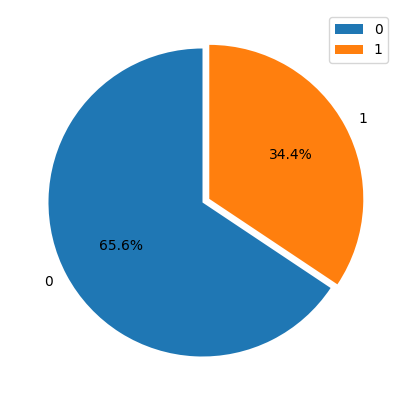

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.pie(value_count.values/np.sum(value_count.values),
       autopct = lambda x: '{:.1f}%'.format(x),
       labels = value_count.index,
       startangle = 90,
       explode=[0, 0.05])
ax.legend();

In [48]:
se_corr = df.corr()["target"].sort_values(ascending=False).iloc[1:]
se_corr

X6     0.309136
X15    0.242305
X7     0.011409
X17    0.011348
X2     0.006620
X1     0.006287
X13    0.003789
X12    0.000986
X10   -0.000242
X16   -0.000422
X3    -0.001705
X19   -0.006328
X11   -0.006625
X14   -0.007021
X0    -0.047974
X9    -0.129168
X18   -0.137856
X8    -0.179548
X5    -0.182394
X4    -0.245310
Name: target, dtype: float64

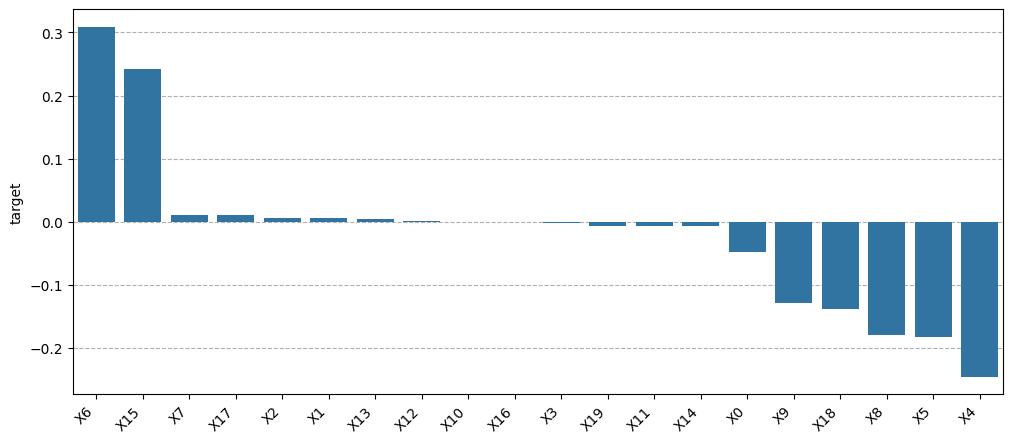

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_axisbelow(True)
ax.yaxis.grid(linestyle = 'dashed')
sns.barplot(se_corr)
plt.xticks(rotation = 45, ha='right');

# Dataset Preparation

Prepare the train & test sets with a size of the latter equal to 10% of the entire data population.

In [66]:
X = df.drop("target", axis = 1)
y = df["target"]

In [67]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [70]:
X_train.shape, X_test.shape

((15000, 20), (5000, 20))

# Model Experiements

Now, import the following classifier classes:
- AdaBoostClassifier
- GradientBoostingClassifier
- RandomForestClassifier
- HistGradientBoostingClassifier
- DecisionTreeClassifier

and these classification metrics:
- accuracy_score, roc_curve, roc_auc_score

The goal is to train and evaluate classification models, and measure their execution times. In order to achieve, it is recommended to develop a piece of code (either a set classes or functions ) and have a systematic approach to our experiment. Think about writing such a program which will allow you to repeat the experiements iteratively and consistently.

The experiement setup includes the following class tunes:

- stump decision tree with maximum depth 2
- deep decision tree with maximum depth 5
- random forest with 100 shallow trees
- random forest with 100 deep trees
- adaptive boosted decision trees  with 10 estimators used in boosting
- adaptive boosted decision trees  with 100 estimators used in boosting
- gradient boosted decision trees  with 10 estimators used in boosting
- gradient boosted decision trees  with 100 estimators used in boosting
- histogram-based gradient boosted decision trees  with maximum depth of 2 and 10 maximum tries for the boosting process
- histogram-based gradient boosted decision trees  with maximum depth of 2 and 100 maximum tries for the boosting process
- histogram-based gradient boosted decision trees  with maximum depth of 5 and 10 maximum tries for the boosting process
- histogram-based gradient boosted decision trees  with maximum depth of 5 and 100 maximum tries for the boosting process

Record and then report the following measurements:

- algorithm speed (training time)
- accuracy over the test set
- model overfitting defined as `accuracy_train/ accuracy_test-1`
- ROC-AUC over the test set
- model overfitting defined as `roc_auc_train/ roc_auc_test-1`
- cross-validated mean accuracy of the test folds
- mean time of cross-validation

The cross-validation should use a stratified k-fold strategy with $k=5$.

Bonus task:
- overlay and compare the ROC curves of all models

**Happy coding!**

In [78]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

In [79]:
from dataclasses import dataclass, field
from typing import Any, Union

In [81]:
@dataclass
class BoostModel:
    name: str
    model: Union[AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, DecisionTreeClassifier]
    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    # derived attributes
    features: list[str] = field(init=None)
    y_train_pred_cls: Any = field(init=None)
    y_train_pred_prb: Any = field(init=None)
    y_test_pred_cls: Any = field(init=None)
    y_test_pred_prb: Any = field(init=None)
    accuracy_train: float = field(init=None)
    accuracy_test: float = field(init=None)
    overfit: float = field(init=None)
    importances: pd.Series = field(init=None)
    ftr_test: Any = field(init=None)
    tpr_test: Any = field(init=None)
    roc_auc_score_test: Any = field(init=None)
        
    @property
    def report(self)->dict[str, float]:
        return {
            "model": self.name,
            "accuracy train": self.accuracy_train, 
            "accuracy test": self.accuracy_test,
            "overfit": self.accuracy_train/self.accuracy_test - 1
               }
    
        

    def __post_init__(self):
        self.features = self.X_train.columns.to_list()
        
        self.model = self.model.fit(self.X_train, self.y_train)
        
        self.y_train_pred_cls = self.model.predict(self.X_train) 
        self.y_train_pred_prb = self.model.predict_proba(self.X_train)
        
        self.y_test_pred_cls = self.model.predict(self.X_test)
        self.y_test_pred_prb = self.model.predict_proba(self.X_test)
        
        self.accuracy_train = accuracy_score(self.y_train, self.y_train_pred_cls)
        self.accuracy_test = accuracy_score(self.y_test, self.y_test_pred_cls)
        
        self.fpr_test, self.tpr_test, _ = roc_curve(y_true=self.y_test, 
                                                    y_score=self.y_test_pred_prb[:,1])
        
        self.roc_auc_score_test = roc_auc_score(y_true=self.y_test, 
                                                y_score=self.y_test_pred_prb[:,1])
        
        self.importances = pd.Series(self.model.feature_importances_, index=self.features).sort_values(ascending=False)

# Observations

Provided in the "Solutions" notebook.

# Outstanding!